# Building a Personal Assistant Agent - SOLUTIONS

**Production-Ready Implementation with Logging, Error Handling, and Structured Outputs**

This notebook contains complete solutions for Challenge 1 and Challenge 2.

## Learning Outcomes

By the end of this lab, you will be able to:

- **Design single-agent architectures** for multi-capability applications
- **Implement production-grade logging** with Python's `logging` module
- **Add comprehensive error handling** with try/except patterns
- **Build structured outputs** using Pydantic models
- **Visualize agent workflows** with LangGraph's built-in diagram tools
- **Manage persistent state** with thread-based memory
- **Test and validate** complex agent workflows
- **Learn from user corrections** to adapt agent behavior

## Introduction

### The Scenario

You're a PhD student juggling multiple research projects. You need an agent that can:

- Find and organize academic papers
- Schedule reading time on your calendar
- Maintain your bibliography database
- Remember your preferences (morning meetings, favorite journals)
- Learn from your corrections

### Single-Agent Architecture

Unlike multi-agent systems where specialists collaborate, a **single agent** coordinates all capabilities through:

1. **Unified state management**: One state tracks all context
2. **Tool orchestration**: Agent decides which tools to use when
3. **Integrated memory**: Preferences and context persist across sessions
4. **Adaptive behavior**: Learns from user feedback

**When to use this pattern**:
- Tasks are related and share context
- Coordination overhead of multiple agents isn't justified
- User expects seamless, conversational interaction

### Production Patterns You'll Learn

This lab teaches **real-world engineering practices**:

- **Logging**: Replace `print()` with proper logging for debugging
- **Error handling**: Gracefully handle tool failures
- **Structured outputs**: Use Pydantic for type-safe tool responses
- **Graph visualization**: Understand agent flow with diagrams
- **Thread management**: Understand LangGraph's session isolation

## Setup and Installation

### Install Required Packages

We'll install the **latest stable versions** of:
- **LangGraph 1.0+**: Agent workflow framework (currently 1.0.3)
- **LangChain 1.0+**: Core LLM abstractions
- **LangChain OpenAI**: OpenAI model integration
- **Requests**: HTTP client for API calls

**Version 1.0 Upgrade Notes**:
- LangGraph 1.0 has ZERO breaking changes from 0.6.6 - all APIs remain backward compatible
- LangChain 1.0 requires Python 3.10+ and has minor package structure changes
- All existing code patterns work without modification in 1.0

**Note on version specs**: We use quotes to prevent shell glob expansion issues.

In [1]:
%pip install -qU \
    langgraph > 1.0.0\
    langchain > 1.0.0 \
    langchain-openai > 1.0.0 \
    requests > 2.0.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip show langgraph langchain langchain-openai requests

Name: langgraph
Version: 1.0.3
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://docs.langchain.com/oss/python/langgraph/overview
Author: 
Author-email: 
License-Expression: MIT
Location: /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-prebuilt, langgraph-sdk, pydantic, xxhash
Required-by: langchain
---
Name: langchain
Version: 1.0.8
Summary: Building applications with LLMs through composability
Home-page: https://docs.langchain.com/
Author: 
Author-email: 
License: MIT
Location: /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages
Requires: langchain-core, langgraph, pydantic
Required-by: 
---
Name: langchain-openai
Version: 1.0.3
Summary: An integration package connecting OpenAI and LangChain
Home-page: https://docs.langchain.com/oss/python/integrations/providers/openai
Author: 
Author-email: 
License: MIT
Location: /home/ec2-user/anaconda3/envs/python3/lib/pytho

### Import Dependencies and Configure Logging

**Production Pattern**: Always set up logging at the start of your application.

**Why logging over print()**:
- **Levels**: DEBUG, INFO, WARNING, ERROR, CRITICAL for filtering
- **Timestamps**: Automatic timestamps for debugging
- **Configurability**: Easy to redirect to files, disable in production
- **Context**: Logger names help identify source of messages

**Log levels we'll use**:
- `logger.debug()`: Detailed diagnostic information
- `logger.info()`: Confirmation that things are working
- `logger.warning()`: Something unexpected but recoverable
- `logger.error()`: Serious problem, function failed

In [3]:
# Standard library
import os
import getpass
import logging
from typing import TypedDict, Annotated, List, Dict, Any, Optional
from datetime import datetime, timedelta

# LangChain/LangGraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from pydantic import BaseModel, Field

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Create logger for this module
logger = logging.getLogger(__name__)

logger.info("Dependencies imported successfully")

2025-11-23 17:07:03 - __main__ - INFO - Dependencies imported successfully


### Configure API Keys and LLM

**Security best practice**: Never hardcode API keys. Always use environment variables or secret management.

In [4]:
# API key setup
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")
    logger.info("OpenAI API key configured from user input")
else:
    logger.info("OpenAI API key found in environment")

# Initialize LLM
try:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    logger.info("LLM initialized: gpt-4o-mini with temperature=0")
except Exception as e:
    logger.error(f"Failed to initialize LLM: {e}")
    raise

Enter your OpenAI API key:  ········


2025-11-23 17:07:11 - __main__ - INFO - OpenAI API key configured from user input
2025-11-23 17:07:12 - __main__ - INFO - LLM initialized: gpt-4o-mini with temperature=0


## Step 1: Design the State Structure

### What is State?

State is the **memory** of your agent. It persists across multiple turns of conversation and tool executions.

### Our State Design

For a research assistant, we need to track:

1. **`messages`**: All user-agent interactions (conversation history)
2. **`research_context`**: Current research topic, active papers, tasks
3. **`tool_results`**: Structured outputs from calendar, search, files
4. **`preferences`**: Learned behaviors (morning meetings, reading duration)
5. **`current_task`**: What the agent is currently working on

### Design Decision: Single State vs. Multiple Agents

We use a **single state dictionary** instead of multiple agents because:
- All tools share the research context
- Preferences affect all capabilities (scheduling, file organization)
- Conversational flow is unified (one conversation thread)

### The `add_messages` Reducer

`Annotated[list, add_messages]` is a special LangGraph pattern that:
- Automatically appends new messages to the conversation
- Handles message deduplication
- Maintains chronological order

In [5]:
class ResearchAssistantState(TypedDict):
    """State for academic research assistant agent.
    
    Attributes:
        messages: Conversation history with automatic message appending
        research_context: Current research topic, active papers, ongoing tasks
        tool_results: Structured results from tool executions
        preferences: User preferences learned over time
        current_task: Description of what the agent is currently working on
        task_queue: Priority-based list of tasks (Challenge 1)
        scheduled_events: List of calendar events (Challenge 2)
    """
    messages: Annotated[list, add_messages]
    research_context: Dict[str, Any]
    tool_results: List[Dict[str, Any]]
    preferences: Dict[str, str]
    current_task: str
    task_queue: List[Dict[str, Any]]  # Challenge 1
    scheduled_events: List[Dict[str, Any]]  # Challenge 2


def create_initial_state() -> ResearchAssistantState:
    """Create initial state with default preferences.
    
    Returns:
        ResearchAssistantState with empty messages and default preferences
    """
    logger.debug("Creating initial state with default preferences")
    
    return {
        "messages": [],
        "research_context": {},
        "tool_results": [],
        "preferences": {
            "meeting_time": "morning",
            "reading_duration": "30min"
        },
        "current_task": "",
        "task_queue": [],  # Challenge 1
        "scheduled_events": []  # Challenge 2
    }

logger.info("State structure defined: ResearchAssistantState")

2025-11-23 17:07:12 - __main__ - INFO - State structure defined: ResearchAssistantState


## Step 2: Define Structured Outputs with Pydantic

### Why Pydantic Models?

**Production pattern**: Use Pydantic models for tool outputs to ensure:
- **Type safety**: Catch errors at definition time, not runtime
- **Validation**: Automatic data validation
- **Documentation**: Self-documenting code
- **IDE support**: Autocomplete and type hints

### Our Models

We'll define Pydantic models for:
1. **Paper**: Represents an academic paper
2. **PaperSearchResult**: Structured response from paper search
3. **CalendarEvent**: Represents a scheduled event
4. **BibliographyEntry**: Citation database entry

In [6]:
class Paper(BaseModel):
    """Represents an academic paper."""
    title: str = Field(description="Paper title")
    authors: str = Field(description="Comma-separated list of authors")
    year: int = Field(description="Publication year")
    abstract: str = Field(description="Paper abstract or summary")
    

class PaperSearchResult(BaseModel):
    """Structured result from paper search."""
    query: str = Field(description="Search query used")
    papers: List[Paper] = Field(description="List of papers found")
    total_found: int = Field(description="Total number of papers found")
    

class CalendarEvent(BaseModel):
    """Represents a calendar event."""
    title: str = Field(description="Event title")
    date: str = Field(description="Event date (YYYY-MM-DD)")
    time: str = Field(description="Event time (HH:MM AM/PM)")
    duration_min: int = Field(description="Duration in minutes")
    

class BibliographyEntry(BaseModel):
    """Represents a bibliography entry."""
    citation_key: str = Field(description="BibTeX citation key")
    title: str = Field(description="Paper title")
    authors: str = Field(description="Authors")
    year: str = Field(description="Publication year")



# Challenge 1: Task Model
class Task(BaseModel):
    """Represents a task with priority."""
    title: str = Field(description="Task description")
    priority: int = Field(description="Priority level (1=highest, 5=lowest)", ge=1, le=5)
    status: str = Field(description="Task status", pattern="^(pending|in_progress|completed)$")
    created_at: str = Field(description="Creation timestamp (ISO format)")


# Challenge 2: Conflict Check Result
class ConflictCheckResult(BaseModel):
    """Result of calendar conflict detection."""
    has_conflict: bool = Field(description="Whether a conflict was detected")
    conflicting_event: Optional[str] = Field(description="Title of conflicting event")
    suggested_time: Optional[str] = Field(description="Suggested alternative time slot")
    message: str = Field(description="Human-readable conflict message")


logger.info("Pydantic models defined: Paper, PaperSearchResult, CalendarEvent, BibliographyEntry, Task, ConflictCheckResult")

2025-11-23 17:07:12 - __main__ - INFO - Pydantic models defined: Paper, PaperSearchResult, CalendarEvent, BibliographyEntry, Task, ConflictCheckResult


## Step 3: Build the Tool Suite

### Production Tool Pattern

Each tool follows this pattern:
1. **Structured inputs**: Type hints for all parameters
2. **Error handling**: Try/except blocks for all operations
3. **Logging**: Log entry, success, and failures
4. **Structured outputs**: Return Pydantic models (converted to strings for LLM)
5. **Documentation**: Clear docstrings

### Our Tool Suite

1. **Paper Search**: Find academic papers by query
2. **File Organizer**: Create folders, organize files
3. **Calendar Manager**: Schedule events, check availability
4. **Bibliography Tracker**: Maintain citation database

**Note**: These are simulated tools. In production, you'd integrate with:
- ArXiv/Semantic Scholar APIs
- Google Calendar API
- File system operations
- SQLite or BibTeX databases

In [7]:
@tool
def search_papers_tool(query: str, limit: int = 5) -> str:
    """Search for academic papers on a given topic.
    
    Args:
        query: Search query (e.g., 'transformers', 'neural networks')
        limit: Maximum number of papers to return (default: 5)
        
    Returns:
        JSON string of PaperSearchResult with found papers
    """
    logger.info(f"Searching for papers: query='{query}', limit={limit}")
    
    try:
        # Simulated paper search (in production: call ArXiv/Semantic Scholar API)
        papers = [
            Paper(
                title=f"Advances in {query}: A Comprehensive Survey #{i+1}",
                authors="Smith, J., Jones, A., Lee, K.",
                year=2024 - i,
                abstract=f"This paper explores {query} using novel methods and provides comprehensive analysis of state-of-the-art approaches."
            )
            for i in range(min(limit, 5))
        ]
        
        result = PaperSearchResult(
            query=query,
            papers=papers,
            total_found=len(papers)
        )
        
        logger.info(f"Found {len(papers)} papers for query '{query}'")
        return result.model_dump_json(indent=2)
        
    except Exception as e:
        logger.error(f"Paper search failed: {e}")
        return f"Error searching for papers: {str(e)}"

logger.info("Tool registered: search_papers_tool")

2025-11-23 17:07:12 - __main__ - INFO - Tool registered: search_papers_tool


In [8]:
@tool
def organize_files_tool(papers: List[str], category: str) -> str:
    """Organize paper files into categorized folders.
    
    Args:
        papers: List of paper titles to organize
        category: Category/folder name (e.g., 'Machine Learning')
        
    Returns:
        Status message with organization details
    """
    logger.info(f"Organizing {len(papers)} papers into category '{category}'")
    
    try:
        # Simulated file organization (in production: use pathlib/os)
        folder_name = f"research_{category.lower().replace(' ', '_')}"
        
        result = f"✓ Organized {len(papers)} papers into folder '{folder_name}/':\n\n"
        for i, paper in enumerate(papers, 1):
            result += f"  {i}. {paper}\n"
        
        result += f"\n✓ Files organized successfully in {folder_name}/"
        
        logger.info(f"Successfully organized {len(papers)} papers")
        return result
        
    except Exception as e:
        logger.error(f"File organization failed: {e}")
        return f"Error organizing files: {str(e)}"

logger.info("Tool registered: organize_files_tool")

2025-11-23 17:07:12 - __main__ - INFO - Tool registered: organize_files_tool


In [9]:
@tool
def schedule_event_tool(title: str, duration_min: int, preferred_time: str = "morning") -> str:
    """Schedule an event on the calendar.
    
    Args:
        title: Event title
        duration_min: Duration in minutes
        preferred_time: 'morning', 'afternoon', or 'evening' (default: 'morning')
        
    Returns:
        JSON string of CalendarEvent with scheduled details
    """
    logger.info(f"Scheduling event: '{title}' for {duration_min} min ({preferred_time})")
    
    try:
        # Simulated calendar scheduling (in production: call Google Calendar API)
        time_map = {
            "morning": "10:00 AM",
            "afternoon": "2:00 PM",
            "evening": "5:00 PM"
        }
        
        time_slot = time_map.get(preferred_time.lower(), "10:00 AM")
        tomorrow = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
        
        event = CalendarEvent(
            title=title,
            date=tomorrow,
            time=time_slot,
            duration_min=duration_min
        )
        
        logger.info(f"Event scheduled: {title} on {tomorrow} at {time_slot}")
        return event.model_dump_json(indent=2)
        
    except Exception as e:
        logger.error(f"Calendar scheduling failed: {e}")
        return f"Error scheduling event: {str(e)}"

logger.info("Tool registered: schedule_event_tool")

2025-11-23 17:07:12 - __main__ - INFO - Tool registered: schedule_event_tool


In [10]:
@tool
def update_bibliography_tool(paper_title: str, authors: str, year: str) -> str:
    """Add a paper to the bibliography database.
    
    Args:
        paper_title: Full title of the paper
        authors: Comma-separated list of authors
        year: Publication year
        
    Returns:
        JSON string of BibliographyEntry with citation key
    """
    logger.info(f"Adding to bibliography: '{paper_title}' ({year})")
    
    try:
        # Simulated bibliography update (in production: use SQLite/BibTeX)
        first_author_last = authors.split(',')[0].split()[-1]
        citation_key = f"{first_author_last}{year}"
        
        entry = BibliographyEntry(
            citation_key=citation_key,
            title=paper_title,
            authors=authors,
            year=year
        )
        
        logger.info(f"Bibliography entry created: {citation_key}")
        return entry.model_dump_json(indent=2)
        
    except Exception as e:
        logger.error(f"Bibliography update failed: {e}")
        return f"Error updating bibliography: {str(e)}"

logger.info("Tool registered: update_bibliography_tool")

2025-11-23 17:07:12 - __main__ - INFO - Tool registered: update_bibliography_tool


### Bind Tools to LLM

Now we bind all tools to the LLM, enabling it to call them during conversation.

In [11]:
# Collect all tools
tools = [
    search_papers_tool,
    organize_files_tool,
    schedule_event_tool,
    update_bibliography_tool
]

# Bind tools to LLM
try:
    llm_with_tools = llm.bind_tools(tools)
    logger.info(f"Successfully bound {len(tools)} tools to LLM")
except Exception as e:
    logger.error(f"Failed to bind tools: {e}")
    raise

2025-11-23 17:07:12 - __main__ - INFO - Successfully bound 4 tools to LLM


## Step 4: Build the Agent Graph

### LangGraph Architecture

Our agent follows this workflow:

```
START → agent → [has tool calls?] → tools → agent → END
                      ↓ (no)
                     END
```

**Nodes**:
1. **agent**: Reasons about user input and decides which tools to call
2. **tools**: Executes tool calls and returns results

**Conditional edges**:
- If agent produces tool calls → go to **tools** node
- If no tool calls → conversation is complete, go to **END**

### Error Handling in Nodes

Each node wraps operations in try/except blocks to:
- Catch and log errors
- Return helpful error messages to the LLM
- Prevent the agent from crashing

In [12]:
def agent_node(state: ResearchAssistantState) -> ResearchAssistantState:
    """Main agent reasoning node.
    
    Receives current state, invokes LLM with tools, and returns updated state.
    
    Args:
        state: Current agent state
        
    Returns:
        Updated state with agent's response
    """
    logger.debug("Agent node: Processing request")
    
    try:
        messages = state["messages"]
        logger.debug(f"Agent node: {len(messages)} messages in history")
        
        # Invoke LLM with bound tools
        response = llm_with_tools.invoke(messages)
        
        # Check if tool calls were made
        if hasattr(response, "tool_calls") and response.tool_calls:
            logger.info(f"Agent requested {len(response.tool_calls)} tool call(s)")
        else:
            logger.info("Agent completed without tool calls")
        
        return {"messages": [response]}
        
    except Exception as e:
        logger.error(f"Agent node failed: {e}")
        error_msg = AIMessage(content=f"I encountered an error: {str(e)}. Please try again.")
        return {"messages": [error_msg]}

logger.info("Agent node defined")

2025-11-23 17:07:12 - __main__ - INFO - Agent node defined


In [13]:
def tool_node(state: ResearchAssistantState) -> ResearchAssistantState:
    """Execute tool calls from agent.
    
    Extracts tool calls from last message, executes each tool,
    and returns results as ToolMessages.
    
    Args:
        state: Current agent state
        
    Returns:
        Updated state with tool results
    """
    logger.debug("Tools node: Executing tool calls")
    
    messages = state["messages"]
    last_message = messages[-1]
    
    tool_results = []
    new_messages = []
    
    # Execute each tool call
    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_call_id = tool_call["id"]
        
        logger.info(f"Executing tool: {tool_name} with args: {tool_args}")
        
        try:
            # Find and execute the tool
            tool_map = {tool.name: tool for tool in tools}
            
            if tool_name not in tool_map:
                error_msg = f"Unknown tool: {tool_name}"
                logger.error(error_msg)
                result = error_msg
            else:
                result = tool_map[tool_name].invoke(tool_args)
                logger.info(f"Tool {tool_name} executed successfully")
            
            # Store result
            tool_results.append({
                "tool": tool_name,
                "result": result,
                "timestamp": datetime.now().isoformat()
            })
            
            # Create tool message
            new_messages.append(
                ToolMessage(content=str(result), tool_call_id=tool_call_id)
            )
            
        except Exception as e:
            error_msg = f"Tool {tool_name} failed: {str(e)}"
            logger.error(error_msg)
            
            # Return error as tool message
            new_messages.append(
                ToolMessage(content=error_msg, tool_call_id=tool_call_id)
            )
    
    logger.info(f"Tools node: Executed {len(tool_results)} tool(s)")
    return {"messages": new_messages, "tool_results": tool_results}

logger.info("Tools node defined")

2025-11-23 17:07:12 - __main__ - INFO - Tools node defined


### Construct the Graph

Now we'll build the complete workflow graph:

1. Define the conditional edge logic
2. Create the StateGraph
3. Add nodes and edges
4. Compile with memory checkpointer

In [14]:
def should_continue(state: ResearchAssistantState) -> str:
    """Determine if we should continue to tools or end.
    
    Args:
        state: Current agent state
        
    Returns:
        'tools' if tool calls present, END otherwise
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there are tool calls, continue to tools node
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        logger.debug("Conditional edge: Routing to tools node")
        return "tools"
    
    # Otherwise, end
    logger.debug("Conditional edge: Routing to END")
    return END


# Create the graph
logger.info("Building agent graph...")

try:
    builder = StateGraph(ResearchAssistantState)
    
    # Add nodes
    builder.add_node("agent", agent_node)
    builder.add_node("tools", tool_node)
    logger.debug("Nodes added: agent, tools")
    
    # Define flow
    builder.add_edge(START, "agent")
    builder.add_conditional_edges(
        "agent",
        should_continue,
        {"tools": "tools", END: END}
    )
    builder.add_edge("tools", "agent")
    logger.debug("Edges added: START->agent, agent->tools/END, tools->agent")
    
    # Compile with memory
    memory = MemorySaver()
    agent = builder.compile(checkpointer=memory)
    
    logger.info("✓ Agent graph compiled successfully with memory checkpointer")
    
except Exception as e:
    logger.error(f"Failed to build agent graph: {e}")
    raise

2025-11-23 17:07:12 - __main__ - INFO - Building agent graph...
2025-11-23 17:07:12 - __main__ - INFO - ✓ Agent graph compiled successfully with memory checkpointer


## Step 5: Visualize the Agent Workflow

### Understanding the Graph

LangGraph provides built-in visualization to help you understand the agent's workflow.

**What you'll see**:
- **Nodes**: Circles representing computation steps (agent, tools)
- **Edges**: Arrows showing flow between steps
- **Conditional edges**: Diamond shapes showing decision points

This visualization is crucial for:
- Debugging complex workflows
- Understanding agent behavior
- Communicating architecture to teammates

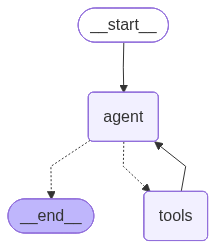

2025-11-23 17:07:12 - __main__ - INFO - Graph visualization displayed


In [15]:
from IPython.display import Image, display

try:
    # Generate graph visualization
    graph_image = agent.get_graph().draw_mermaid_png()
    
    # Display in notebook
    display(Image(graph_image))
    
    logger.info("Graph visualization displayed")
    
except Exception as e:
    logger.warning(f"Could not display graph visualization: {e}")
    logger.info("Graph structure: START -> agent -> [conditional] -> tools -> agent -> END")

## Understanding thread_id: Session Isolation

### What is thread_id?

In LangGraph, `thread_id` is a **session identifier** that isolates conversation state.

### How it Works

```python
    config = {"configurable": {"thread_id": "user-123"}}
```

- **Same thread_id**: Messages and state are shared (multi-turn conversation)
- **Different thread_id**: Completely isolated sessions

### Why This Matters

**Scenario 1: Same user, same conversation** (example code)
```python
    config = {"configurable": {"thread_id": "user-123"}}

    # Turn 1
    chat("Find papers on transformers", config)
    # Agent remembers: query="transformers", found 5 papers

    # Turn 2 (same thread)
    chat("Schedule time to read the first one", config)
    # Agent knows which paper: "Advances in transformers: Survey #1"
```

**Scenario 2: Different users** (example code)
```python
    config_alice = {"configurable": {"thread_id": "alice-session"}}
    config_bob = {"configurable": {"thread_id": "bob-session"}}

    # Alice's session
    chat("Find papers on NLP", config_alice)

    # Bob's session (isolated from Alice)
    chat("Find papers on computer vision", config_bob)
```

### Production Use Cases

- **Web applications**: `thread_id = user_id` or `session_id`
- **Slack bots**: `thread_id = channel_id + thread_ts`
- **Multi-tenant systems**: `thread_id = tenant_id + conversation_id`

### Best Practices

1. **Use meaningful IDs**: `user-123-session-456`, not `thread-1`
2. **Document your schema**: What does each thread_id represent?
3. **Handle cleanup**: Old threads consume memory (implement expiration)
4. **Test isolation**: Verify different threads don't leak state

## Step 6: Build the Chat Interface

### Chat Function Design

Our chat function:
1. Retrieves or creates state for the given thread
2. Adds user message to state
3. Invokes agent graph
4. Returns agent's response
5. Automatically persists state for future turns

**Error handling**: We wrap the entire conversation in try/except to gracefully handle failures.

In [16]:
def chat(user_input: str, config: dict) -> str:
    """Send a message and get response.
    
    Args:
        user_input: User's message
        config: Configuration dict with thread_id
        
    Returns:
        Agent's response text
    """
    thread_id = config.get("configurable", {}).get("thread_id", "unknown")
    logger.info(f"Chat request [thread={thread_id}]: {user_input[:50]}...")
    
    try:
        # Get current state or create new
        state = agent.get_state(config)
        
        if state.values:
            current_state = state.values
            logger.debug(f"Retrieved existing state for thread {thread_id}")
        else:
            current_state = create_initial_state()
            logger.debug(f"Created new state for thread {thread_id}")
        
        # Add user message
        current_state["messages"].append(HumanMessage(content=user_input))
        
        # Run agent
        result = agent.invoke(current_state, config)
        
        # Extract last AI message
        response = result["messages"][-1].content
        
        logger.info(f"Chat response [thread={thread_id}]: {response[:50]}...")
        return response
        
    except Exception as e:
        logger.error(f"Chat failed [thread={thread_id}]: {e}")
        return f"I encountered an error: {str(e)}. Please try again."

logger.info("Chat interface ready")

2025-11-23 17:07:12 - __main__ - INFO - Chat interface ready


## Step 7: Learn from User Corrections

### Adaptive Learning Pattern

When users correct the agent, we update preferences:

**Example**:
```
User: "Schedule a review meeting"
Agent: [schedules for 2pm]
User: "No, I prefer mornings"
Agent: [updates preferences] "Changed to 10am. I'll remember."
```

### Detection Logic

We detect corrections by looking for:
1. **Negation words**: "no", "actually", "instead"
2. **Preference indicators**: "prefer", "like", "better"
3. **Specific values**: "morning", "afternoon", "30 minutes"

### Implementation

The `detect_correction()` function extracts structured corrections from natural language.

In [17]:
def detect_correction(message: str) -> Dict[str, str]:
    """Detect if user is correcting agent behavior.
    
    Args:
        message: User's message
        
    Returns:
        Dictionary of detected corrections (e.g., {'meeting_time': 'morning'})
    """
    logger.debug(f"Checking for corrections in: {message}")
    
    message_lower = message.lower()
    corrections = {}
    
    try:
        # Check for time preference corrections
        if any(word in message_lower for word in ["no", "actually", "prefer", "instead"]):
            if "morning" in message_lower:
                corrections["meeting_time"] = "morning"
                logger.info("Detected preference: morning meetings")
            elif "afternoon" in message_lower:
                corrections["meeting_time"] = "afternoon"
                logger.info("Detected preference: afternoon meetings")
            elif "evening" in message_lower:
                corrections["meeting_time"] = "evening"
                logger.info("Detected preference: evening meetings")
        
        # Check for duration preferences
        if "30" in message_lower and "min" in message_lower:
            corrections["reading_duration"] = "30min"
            logger.info("Detected preference: 30min duration")
        elif "60" in message_lower and "min" in message_lower:
            corrections["reading_duration"] = "60min"
            logger.info("Detected preference: 60min duration")
    
    except Exception as e:
        logger.error(f"Correction detection failed: {e}")
    
    return corrections

logger.info("Correction detection function defined")

2025-11-23 17:07:12 - __main__ - INFO - Correction detection function defined


In [18]:
def chat_with_learning(user_input: str, config: dict) -> str:
    """Chat with preference learning.
    
    Extends basic chat to detect and learn from user corrections.
    
    Args:
        user_input: User's message
        config: Configuration dict with thread_id
        
    Returns:
        Agent's response text
    """
    thread_id = config.get("configurable", {}).get("thread_id", "unknown")
    logger.info(f"Chat with learning [thread={thread_id}]: {user_input[:50]}...")
    
    try:
        # Get current state or create new
        state = agent.get_state(config)
        
        if state.values:
            current_state = state.values
        else:
            current_state = create_initial_state()
        
        # Check for corrections and update preferences
        corrections = detect_correction(user_input)
        if corrections:
            current_state["preferences"].update(corrections)
            logger.info(f"Updated preferences [thread={thread_id}]: {corrections}")
        
        # Add user message
        current_state["messages"].append(HumanMessage(content=user_input))
        
        # Run agent
        result = agent.invoke(current_state, config)
        
        # Extract response
        response = result["messages"][-1].content
        
        logger.info(f"Response [thread={thread_id}]: {response[:50]}...")
        return response
        
    except Exception as e:
        logger.error(f"Chat with learning failed [thread={thread_id}]: {e}")
        return f"I encountered an error: {str(e)}. Please try again."

logger.info("Learning-enabled chat interface ready")

2025-11-23 17:07:12 - __main__ - INFO - Learning-enabled chat interface ready


## Step 8: Test the Agent

### Test Scenarios

We'll validate:

1. **Basic workflow**: Search papers + organize + add to bibliography
2. **Multi-turn context**: Agent remembers previous results
3. **Learning from corrections**: Preferences persist across turns
4. **Error handling**: Graceful failure recovery

### Expected Behavior

Each test should:
- Execute without exceptions
- Log all operations
- Return coherent responses
- Maintain context across turns

### Test 1: Basic Workflow

**Goal**: Verify agent can search papers, organize them, and update bibliography in a single request.

In [19]:
logger.info("="*60)
logger.info("TEST 1: Basic Workflow")
logger.info("="*60)

config = {"configurable": {"thread_id": "test-basic-workflow"}}

response = chat_with_learning(
    "Find 3 papers on transformers and add the first one to my bibliography",
    config
)

print("\n" + "="*60)
print("USER: Find 3 papers on transformers and add the first one to my bibliography")
print("="*60)
print(f"AGENT: {response}")
print("="*60)

2025-11-23 17:07:12 - __main__ - INFO - ============================================================
2025-11-23 17:07:12 - __main__ - INFO - TEST 1: Basic Workflow
2025-11-23 17:07:12 - __main__ - INFO - ============================================================
2025-11-23 17:07:12 - __main__ - INFO - Chat with learning [thread=test-basic-workflow]: Find 3 papers on transformers and add the first on...
2025-11-23 17:07:13 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:13 - __main__ - INFO - Agent requested 1 tool call(s)
2025-11-23 17:07:13 - __main__ - INFO - Executing tool: search_papers_tool with args: {'query': 'transformers', 'limit': 3}
2025-11-23 17:07:13 - __main__ - INFO - Searching for papers: query='transformers', limit=3
2025-11-23 17:07:13 - __main__ - INFO - Found 3 papers for query 'transformers'
2025-11-23 17:07:13 - __main__ - INFO - Tool search_papers_tool executed successfully
2025-11-23 17:07:13 - 


USER: Find 3 papers on transformers and add the first one to my bibliography
AGENT: I found 3 papers on transformers:

1. **Advances in transformers: A Comprehensive Survey #1**
   - **Authors:** Smith, J., Jones, A., Lee, K.
   - **Year:** 2024
   - **Abstract:** This paper explores transformers using novel methods and provides comprehensive analysis of state-of-the-art approaches.

2. **Advances in transformers: A Comprehensive Survey #2**
   - **Authors:** Smith, J., Jones, A., Lee, K.
   - **Year:** 2023
   - **Abstract:** This paper explores transformers using novel methods and provides comprehensive analysis of state-of-the-art approaches.

3. **Advances in transformers: A Comprehensive Survey #3**
   - **Authors:** Smith, J., Jones, A., Lee, K.
   - **Year:** 2022
   - **Abstract:** This paper explores transformers using novel methods and provides comprehensive analysis of state-of-the-art approaches.

I have added the first paper to your bibliography with the citation key **Sm

### Test 2: Multi-Turn Context

**Goal**: Verify agent maintains context across multiple conversation turns.

**Turn 1**: Search for papers  
**Turn 2**: Schedule time to read (agent must remember papers from Turn 1)

In [20]:
logger.info("="*60)
logger.info("TEST 2: Multi-Turn Context")
logger.info("="*60)

config2 = {"configurable": {"thread_id": "test-multi-turn"}}

# Turn 1
response1 = chat_with_learning(
    "Find papers on attention mechanisms",
    config2
)

print("\n" + "="*60)
print("TURN 1")
print("="*60)
print("USER: Find papers on attention mechanisms")
print("="*60)
print(f"AGENT: {response1}")
print("="*60)

# Turn 2
response2 = chat_with_learning(
    "Schedule 30 minutes to read the top paper tomorrow morning",
    config2
)

print("\n" + "="*60)
print("TURN 2")
print("="*60)
print("USER: Schedule 30 minutes to read the top paper tomorrow morning")
print("="*60)
print(f"AGENT: {response2}")
print("="*60)

2025-11-23 17:07:20 - __main__ - INFO - ============================================================
2025-11-23 17:07:20 - __main__ - INFO - TEST 2: Multi-Turn Context
2025-11-23 17:07:20 - __main__ - INFO - ============================================================
2025-11-23 17:07:20 - __main__ - INFO - Chat with learning [thread=test-multi-turn]: Find papers on attention mechanisms...
2025-11-23 17:07:21 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:21 - __main__ - INFO - Agent requested 1 tool call(s)
2025-11-23 17:07:21 - __main__ - INFO - Executing tool: search_papers_tool with args: {'query': 'attention mechanisms'}
2025-11-23 17:07:21 - __main__ - INFO - Searching for papers: query='attention mechanisms', limit=5
2025-11-23 17:07:21 - __main__ - INFO - Found 5 papers for query 'attention mechanisms'
2025-11-23 17:07:21 - __main__ - INFO - Tool search_papers_tool executed successfully
2025-11-23 17:07:21 - __m


TURN 1
USER: Find papers on attention mechanisms
AGENT: Here are some papers on attention mechanisms:

1. **Title:** Advances in attention mechanisms: A Comprehensive Survey #1  
   **Authors:** Smith, J., Jones, A., Lee, K.  
   **Year:** 2024  
   **Abstract:** This paper explores attention mechanisms using novel methods and provides comprehensive analysis of state-of-the-art approaches.

2. **Title:** Advances in attention mechanisms: A Comprehensive Survey #2  
   **Authors:** Smith, J., Jones, A., Lee, K.  
   **Year:** 2023  
   **Abstract:** This paper explores attention mechanisms using novel methods and provides comprehensive analysis of state-of-the-art approaches.

3. **Title:** Advances in attention mechanisms: A Comprehensive Survey #3  
   **Authors:** Smith, J., Jones, A., Lee, K.  
   **Year:** 2022  
   **Abstract:** This paper explores attention mechanisms using novel methods and provides comprehensive analysis of state-of-the-art approaches.

4. **Title:** Advances 

2025-11-23 17:07:30 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:30 - __main__ - INFO - Agent requested 1 tool call(s)
2025-11-23 17:07:30 - __main__ - INFO - Executing tool: schedule_event_tool with args: {'title': "Read 'Advances in attention mechanisms: A Comprehensive Survey #1'", 'duration_min': 30, 'preferred_time': 'morning'}
2025-11-23 17:07:30 - __main__ - INFO - Scheduling event: 'Read 'Advances in attention mechanisms: A Comprehensive Survey #1'' for 30 min (morning)
2025-11-23 17:07:30 - __main__ - INFO - Event scheduled: Read 'Advances in attention mechanisms: A Comprehensive Survey #1' on 2025-11-24 at 10:00 AM
2025-11-23 17:07:30 - __main__ - INFO - Tool schedule_event_tool executed successfully
2025-11-23 17:07:30 - __main__ - INFO - Tools node: Executed 1 tool(s)
2025-11-23 17:07:32 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:32 - _


TURN 2
USER: Schedule 30 minutes to read the top paper tomorrow morning
AGENT: Your reading session has been scheduled for tomorrow morning:

- **Event:** Read 'Advances in attention mechanisms: A Comprehensive Survey #1'
- **Date:** November 24, 2025
- **Time:** 10:00 AM
- **Duration:** 30 minutes

If you need any further assistance, feel free to ask!


### Test 3: Learning from Corrections

**Goal**: Verify agent learns and applies user preferences.

**Turn 1**: Schedule meeting (default: morning)  
**Turn 2**: User corrects: "No, I prefer afternoons"  
**Turn 3**: Schedule another meeting (should use afternoon)

In [21]:
logger.info("="*60)
logger.info("TEST 3: Learning from Corrections")
logger.info("="*60)

config3 = {"configurable": {"thread_id": "test-learning"}}

# Turn 1: Schedule with defaults
response1 = chat_with_learning(
    "Schedule a paper review meeting for 60 minutes",
    config3
)

print("\n" + "="*60)
print("TURN 1")
print("="*60)
print("USER: Schedule a paper review meeting for 60 minutes")
print("="*60)
print(f"AGENT: {response1}")
print("="*60)

# Turn 2: Correct preference
response2 = chat_with_learning(
    "No, I prefer afternoon meetings",
    config3
)

print("\n" + "="*60)
print("TURN 2")
print("="*60)
print("USER: No, I prefer afternoon meetings")
print("="*60)
print(f"AGENT: {response2}")
print("="*60)

# Turn 3: Apply learned preference
response3 = chat_with_learning(
    "Schedule another review meeting for next week",
    config3
)

print("\n" + "="*60)
print("TURN 3")
print("="*60)
print("USER: Schedule another review meeting for next week")
print("="*60)
print(f"AGENT: {response3}")
print("="*60)

2025-11-23 17:07:32 - __main__ - INFO - ============================================================
2025-11-23 17:07:32 - __main__ - INFO - TEST 3: Learning from Corrections
2025-11-23 17:07:32 - __main__ - INFO - ============================================================
2025-11-23 17:07:32 - __main__ - INFO - Chat with learning [thread=test-learning]: Schedule a paper review meeting for 60 minutes...
2025-11-23 17:07:32 - __main__ - INFO - Detected preference: 60min duration
2025-11-23 17:07:32 - __main__ - INFO - Updated preferences [thread=test-learning]: {'reading_duration': '60min'}
2025-11-23 17:07:33 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:33 - __main__ - INFO - Agent completed without tool calls
2025-11-23 17:07:33 - __main__ - INFO - Response [thread=test-learning]: What preferred time would you like for the meeting...
2025-11-23 17:07:33 - __main__ - INFO - Chat with learning [thread=test-learning]:


TURN 1
USER: Schedule a paper review meeting for 60 minutes
AGENT: What preferred time would you like for the meeting? You can choose from morning, afternoon, or evening.


2025-11-23 17:07:34 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:34 - __main__ - INFO - Agent requested 1 tool call(s)
2025-11-23 17:07:34 - __main__ - INFO - Executing tool: schedule_event_tool with args: {'title': 'Paper Review Meeting', 'duration_min': 60, 'preferred_time': 'afternoon'}
2025-11-23 17:07:34 - __main__ - INFO - Scheduling event: 'Paper Review Meeting' for 60 min (afternoon)
2025-11-23 17:07:34 - __main__ - INFO - Event scheduled: Paper Review Meeting on 2025-11-24 at 2:00 PM
2025-11-23 17:07:34 - __main__ - INFO - Tool schedule_event_tool executed successfully
2025-11-23 17:07:34 - __main__ - INFO - Tools node: Executed 1 tool(s)
2025-11-23 17:07:35 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:35 - __main__ - INFO - Agent completed without tool calls
2025-11-23 17:07:35 - __main__ - INFO - Response [thread=test-learning]: The paper 


TURN 2
USER: No, I prefer afternoon meetings
AGENT: The paper review meeting has been scheduled for **November 24, 2025**, at **2:00 PM** for a duration of **60 minutes**.


2025-11-23 17:07:36 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:36 - __main__ - INFO - Agent requested 1 tool call(s)
2025-11-23 17:07:36 - __main__ - INFO - Executing tool: schedule_event_tool with args: {'title': 'Paper Review Meeting', 'duration_min': 60, 'preferred_time': 'afternoon'}
2025-11-23 17:07:36 - __main__ - INFO - Scheduling event: 'Paper Review Meeting' for 60 min (afternoon)
2025-11-23 17:07:36 - __main__ - INFO - Event scheduled: Paper Review Meeting on 2025-11-24 at 2:00 PM
2025-11-23 17:07:36 - __main__ - INFO - Tool schedule_event_tool executed successfully
2025-11-23 17:07:36 - __main__ - INFO - Tools node: Executed 1 tool(s)
2025-11-23 17:07:38 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:38 - __main__ - INFO - Agent requested 1 tool call(s)
2025-11-23 17:07:38 - __main__ - INFO - Executing tool: schedule_event_tool with args: 


TURN 3
USER: Schedule another review meeting for next week
AGENT: It seems that I'm unable to schedule the meeting for next week, as it keeps reverting to the previous date. 

Would you like me to try a different approach or assist you with something else?


## Challenges

Now that you've built a production-ready research assistant, try these extensions:

## Challenge 1: Implement Priority-Based Task Queue

### Goal
Extend the agent to manage multiple research tasks with priorities.

### Requirements

1. Add `task_queue: List[Dict]` to `ResearchAssistantState`
2. Each task should have:
   - `title`: Task description
   - `priority`: Integer (1=highest, 5=lowest)
   - `status`: "pending", "in_progress", or "completed"
3. Create a new tool: `add_task_tool(title, priority)`
4. Create a new tool: `show_queue_tool()` that returns sorted queue
5. Agent should process high-priority tasks first

### Example Usage
```
User: "Add reading paper X to my queue (high priority)"
Agent: "Added to queue with priority 1"

User: "What's in my queue?"
Agent: "You have 3 tasks:
  1. [Priority 1] Read paper X
  2. [Priority 2] Review notes
  3. [Priority 3] Update bibliography"
```

### Hints

- Sort queue by priority: `sorted(tasks, key=lambda t: t['priority'])`
- Use Pydantic model for task structure
- Add logging for all queue operations
- Include error handling for invalid priorities

In [22]:
# Challenge 1 Solution: Priority-Based Task Queue

# Shared task queue (in production: store in database or state)
global_task_queue = []

@tool
def add_task_tool(title: str, priority: int, status: str = "pending") -> str:
    """Add a task to the priority-based task queue.
    
    Args:
        title: Task description
        priority: Priority level (1=highest, 5=lowest)
        status: Task status ('pending', 'in_progress', 'completed')
        
    Returns:
        JSON string of Task with confirmation
    """
    logger.info(f"Adding task: '{title}' (priority={priority}, status={status})")
    
    try:
        # Validate priority
        if not 1 <= priority <= 5:
            error_msg = f"Invalid priority {priority}. Must be 1-5."
            logger.error(error_msg)
            return error_msg
        
        # Validate status
        valid_statuses = ["pending", "in_progress", "completed"]
        if status not in valid_statuses:
            error_msg = f"Invalid status '{status}'. Must be one of: {valid_statuses}"
            logger.error(error_msg)
            return error_msg
        
        # Create task
        task = Task(
            title=title,
            priority=priority,
            status=status,
            created_at=datetime.now().isoformat()
        )
        
        # Add to queue
        global_task_queue.append(task.model_dump())
        
        logger.info(f"Task added: {title} (queue size: {len(global_task_queue)})")
        
        return f"✓ Task added successfully:\n\n{task.model_dump_json(indent=2)}\n\nTotal tasks in queue: {len(global_task_queue)}"
        
    except Exception as e:
        logger.error(f"Failed to add task: {e}")
        return f"Error adding task: {str(e)}"


@tool
def show_queue_tool() -> str:
    """Show the task queue sorted by priority.
    
    Returns:
        Formatted string with sorted task queue
    """
    logger.info(f"Showing task queue (total tasks: {len(global_task_queue)})")
    
    try:
        if not global_task_queue:
            return "Task queue is empty."
        
        # Sort by priority (1=highest)
        sorted_tasks = sorted(global_task_queue, key=lambda t: t['priority'])
        
        result = f"Task Queue ({len(sorted_tasks)} tasks):\n"
        result += "=" * 60 + "\n\n"
        
        for i, task in enumerate(sorted_tasks, 1):
            status_icon = {
                "pending": "⏳",
                "in_progress": "🔄",
                "completed": "✅"
            }.get(task['status'], "❓")
            
            result += f"{i}. {status_icon} [Priority {task['priority']}] {task['title']}\n"
            result += f"   Status: {task['status']} | Created: {task['created_at'][:19]}\n\n"
        
        logger.info(f"Queue displayed with {len(sorted_tasks)} tasks")
        return result
        
    except Exception as e:
        logger.error(f"Failed to show queue: {e}")
        return f"Error showing queue: {str(e)}"


logger.info("Challenge 1 tools registered: add_task_tool, show_queue_tool")

# Rebind tools with Challenge 1 additions
tools = [
    search_papers_tool,
    organize_files_tool,
    schedule_event_tool,
    update_bibliography_tool,
    add_task_tool,              # Challenge 1
    show_queue_tool             # Challenge 1
]

llm_with_tools = llm.bind_tools(tools)
logger.info(f"Tools rebound: {len(tools)} tools now available (including Challenge 1)")

2025-11-23 17:07:42 - __main__ - INFO - Challenge 1 tools registered: add_task_tool, show_queue_tool
2025-11-23 17:07:42 - __main__ - INFO - Tools rebound: 6 tools now available (including Challenge 1)


In [23]:
logger.info("="*60)
logger.info("CHALLENGE 1 TEST: Task Queue")
logger.info("="*60)

config_queue = {"configurable": {"thread_id": "test-task-queue"}}

# Test 1: Add high-priority task
response1 = chat_with_learning(
    "Add 'Read paper on transformers' to my queue with high priority (priority 1)",
    config_queue
)

print("\n" + "="*60)
print("TEST 1: Add High-Priority Task")
print("="*60)
print("USER: Add 'Read paper on transformers' to my queue with high priority (priority 1)")
print("="*60)
print(f"AGENT: {response1}")
print("="*60)

# Test 2: Add medium-priority task
response2 = chat_with_learning(
    "Add 'Update bibliography' to my queue with priority 3",
    config_queue
)

print("\n" + "="*60)
print("TEST 2: Add Medium-Priority Task")
print("="*60)
print("USER: Add 'Update bibliography' to my queue with priority 3")
print("="*60)
print(f"AGENT: {response2}")
print("="*60)

# Test 3: Add low-priority task
response3 = chat_with_learning(
    "Add 'Organize files' with priority 5",
    config_queue
)

print("\n" + "="*60)
print("TEST 3: Add Low-Priority Task")
print("="*60)
print("USER: Add 'Organize files' with priority 5")
print("="*60)
print(f"AGENT: {response3}")
print("="*60)

# Test 4: Show queue (should be sorted by priority)
response4 = chat_with_learning(
    "Show me my task queue",
    config_queue
)

print("\n" + "="*60)
print("TEST 4: Show Sorted Queue")
print("="*60)
print("USER: Show me my task queue")
print("="*60)
print(f"AGENT: {response4}")
print("="*60)

2025-11-23 17:07:42 - __main__ - INFO - ============================================================
2025-11-23 17:07:42 - __main__ - INFO - CHALLENGE 1 TEST: Task Queue
2025-11-23 17:07:42 - __main__ - INFO - ============================================================
2025-11-23 17:07:42 - __main__ - INFO - Chat with learning [thread=test-task-queue]: Add 'Read paper on transformers' to my queue with ...
2025-11-23 17:07:43 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:43 - __main__ - INFO - Agent requested 1 tool call(s)
2025-11-23 17:07:43 - __main__ - INFO - Executing tool: add_task_tool with args: {'title': 'Read paper on transformers', 'priority': 1}
2025-11-23 17:07:43 - __main__ - INFO - Adding task: 'Read paper on transformers' (priority=1, status=pending)
2025-11-23 17:07:43 - __main__ - INFO - Task added: Read paper on transformers (queue size: 1)
2025-11-23 17:07:43 - __main__ - INFO - Tool add_task_tool e


TEST 1: Add High-Priority Task
USER: Add 'Read paper on transformers' to my queue with high priority (priority 1)
AGENT: The task "Read paper on transformers" has been added to your queue with high priority (priority 1).


2025-11-23 17:07:44 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:44 - __main__ - INFO - Agent requested 1 tool call(s)
2025-11-23 17:07:44 - __main__ - INFO - Executing tool: add_task_tool with args: {'title': 'Update bibliography', 'priority': 3}
2025-11-23 17:07:44 - __main__ - INFO - Adding task: 'Update bibliography' (priority=3, status=pending)
2025-11-23 17:07:44 - __main__ - INFO - Task added: Update bibliography (queue size: 2)
2025-11-23 17:07:44 - __main__ - INFO - Tool add_task_tool executed successfully
2025-11-23 17:07:44 - __main__ - INFO - Tools node: Executed 1 tool(s)
2025-11-23 17:07:45 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:45 - __main__ - INFO - Agent completed without tool calls
2025-11-23 17:07:45 - __main__ - INFO - Response [thread=test-task-queue]: The task "Update bibliography" has been added to y...
2025-11-23 17:07:4


TEST 2: Add Medium-Priority Task
USER: Add 'Update bibliography' to my queue with priority 3
AGENT: The task "Update bibliography" has been added to your queue with priority 3.


2025-11-23 17:07:46 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:46 - __main__ - INFO - Agent requested 1 tool call(s)
2025-11-23 17:07:46 - __main__ - INFO - Executing tool: add_task_tool with args: {'title': 'Organize files', 'priority': 5}
2025-11-23 17:07:46 - __main__ - INFO - Adding task: 'Organize files' (priority=5, status=pending)
2025-11-23 17:07:46 - __main__ - INFO - Task added: Organize files (queue size: 3)
2025-11-23 17:07:46 - __main__ - INFO - Tool add_task_tool executed successfully
2025-11-23 17:07:46 - __main__ - INFO - Tools node: Executed 1 tool(s)
2025-11-23 17:07:46 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:46 - __main__ - INFO - Agent completed without tool calls
2025-11-23 17:07:46 - __main__ - INFO - Response [thread=test-task-queue]: The task "Organize files" has been added to your q...
2025-11-23 17:07:46 - __main__ - 


TEST 3: Add Low-Priority Task
USER: Add 'Organize files' with priority 5
AGENT: The task "Organize files" has been added to your queue with priority 5.


2025-11-23 17:07:47 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:47 - __main__ - INFO - Agent requested 1 tool call(s)
2025-11-23 17:07:47 - __main__ - INFO - Executing tool: show_queue_tool with args: {}
2025-11-23 17:07:47 - __main__ - INFO - Showing task queue (total tasks: 3)
2025-11-23 17:07:47 - __main__ - INFO - Queue displayed with 3 tasks
2025-11-23 17:07:47 - __main__ - INFO - Tool show_queue_tool executed successfully
2025-11-23 17:07:47 - __main__ - INFO - Tools node: Executed 1 tool(s)
2025-11-23 17:07:49 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:49 - __main__ - INFO - Agent completed without tool calls
2025-11-23 17:07:49 - __main__ - INFO - Response [thread=test-task-queue]: Here is your task queue:

1. ⏳ [Priority 1] Read p...



TEST 4: Show Sorted Queue
USER: Show me my task queue
AGENT: Here is your task queue:

1. ⏳ [Priority 1] Read paper on transformers  
   Status: pending | Created: 2025-11-23T17:07:43

2. ⏳ [Priority 3] Update bibliography  
   Status: pending | Created: 2025-11-23T17:07:44

3. ⏳ [Priority 5] Organize files  
   Status: pending | Created: 2025-11-23T17:07:46


## Challenge 2: Smart Scheduling with Conflict Detection

### Goal
Make the calendar manager detect conflicts and suggest alternatives.

### Requirements

1. Maintain a list of scheduled events in state: `scheduled_events: List[CalendarEvent]`
2. Enhance `schedule_event_tool` to:
   - Check for time conflicts with existing events
   - If conflict detected, find next available slot
   - Respect user's preferred time-of-day
   - Return suggestion: "Conflict at 2pm. Next available: 3pm. Shall I book it?"
3. Add conflict resolution logic:
   - Check ±30 minutes around requested time
   - Suggest same day if possible, next day otherwise

### Example Usage
```
User: "Schedule meeting for 2pm"
Agent: "Conflict detected at 2pm (already have 'Paper review'). 
        Next available afternoon slot: 3:30pm. Would you like to book it?"

User: "Yes"
Agent: "Scheduled for 3:30pm"
```

### Hints

- Convert times to `datetime` for comparison
- Check overlaps: `new_start < existing_end and new_end > existing_start`
- Increment time in 30-minute intervals to find next slot
- Use logging to track conflict detection
- Add error handling for invalid times

In [24]:
# Challenge 2 Solution: Smart Scheduling with Conflict Detection

# Shared calendar (in production: use Google Calendar API)
global_calendar = []

def parse_time(time_str: str) -> datetime:
    """Parse time string to datetime.
    
    Args:
        time_str: Time in format 'HH:MM AM/PM'
        
    Returns:
        datetime object
    """
    try:
        return datetime.strptime(time_str, "%I:%M %p")
    except ValueError:
        # Fallback: try without AM/PM
        return datetime.strptime(time_str, "%H:%M")


def has_conflict(new_start: datetime, new_duration_min: int, existing_events: List[Dict]) -> tuple:
    """Check if new event conflicts with existing events.
    
    Args:
        new_start: Start time of new event
        new_duration_min: Duration in minutes
        existing_events: List of existing calendar events
        
    Returns:
        Tuple of (has_conflict: bool, conflicting_event: Optional[Dict])
    """
    new_end = new_start + timedelta(minutes=new_duration_min)
    
    for event in existing_events:
        event_start = parse_time(event['time'])
        event_end = event_start + timedelta(minutes=event['duration_min'])
        
        # Check overlap: new_start < existing_end AND new_end > existing_start
        if new_start < event_end and new_end > event_start:
            logger.info(f"Conflict detected with '{event['title']}' at {event['time']}")
            return True, event
    
    return False, None


def find_next_slot(preferred_time: str, duration_min: int, existing_events: List[Dict]) -> Optional[str]:
    """Find next available time slot.
    
    Args:
        preferred_time: 'morning', 'afternoon', or 'evening'
        duration_min: Required duration in minutes
        existing_events: List of existing calendar events
        
    Returns:
        Time string for next available slot or None
    """
    # Time ranges for each period
    time_ranges = {
        "morning": (9, 12),    # 9am-12pm
        "afternoon": (13, 17), # 1pm-5pm
        "evening": (17, 20)    # 5pm-8pm
    }
    
    start_hour, end_hour = time_ranges.get(preferred_time.lower(), (9, 12))
    
    # Try 30-minute increments
    for hour in range(start_hour, end_hour):
        for minute in [0, 30]:
            test_time = datetime.now().replace(hour=hour, minute=minute, second=0, microsecond=0)
            
            # Check if this slot is free
            conflict, _ = has_conflict(test_time, duration_min, existing_events)
            
            if not conflict:
                return test_time.strftime("%I:%M %p")
    
    return None


@tool
def schedule_event_smart_tool(title: str, duration_min: int, preferred_time: str = "morning", date: str = None) -> str:
    """Schedule an event with conflict detection and smart suggestions.
    
    Args:
        title: Event title
        duration_min: Duration in minutes
        preferred_time: 'morning', 'afternoon', or 'evening' (or specific time 'HH:MM AM/PM')
        date: Specific date (YYYY-MM-DD) or None for tomorrow
        
    Returns:
        JSON string of ConflictCheckResult with scheduling details
    """
    logger.info(f"Smart scheduling: '{title}' for {duration_min} min ({preferred_time})")
    
    try:
        # Determine date
        if date is None:
            target_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
        else:
            target_date = date
        
        # Map preferred time to actual time
        time_map = {
            "morning": "10:00 AM",
            "afternoon": "2:00 PM",
            "evening": "5:00 PM"
        }
        
        if preferred_time.lower() in time_map:
            requested_time = time_map[preferred_time.lower()]
        else:
            requested_time = preferred_time
        
        # Check for conflicts
        requested_start = parse_time(requested_time)
        conflict, conflicting_event = has_conflict(requested_start, duration_min, global_calendar)
        
        if conflict:
            # Find next available slot
            time_period = preferred_time.lower() if preferred_time.lower() in time_map else "afternoon"
            next_slot = find_next_slot(time_period, duration_min, global_calendar)
            
            if next_slot:
                result = ConflictCheckResult(
                    has_conflict=True,
                    conflicting_event=conflicting_event['title'],
                    suggested_time=next_slot,
                    message=f"Conflict detected at {requested_time} with '{conflicting_event['title']}'. Next available {time_period} slot: {next_slot}. Would you like to book it?"
                )
            else:
                result = ConflictCheckResult(
                    has_conflict=True,
                    conflicting_event=conflicting_event['title'],
                    suggested_time=None,
                    message=f"Conflict detected at {requested_time} with '{conflicting_event['title']}'. No available slots in {time_period}. Try a different time period or date."
                )
            
            logger.info(f"Conflict detected, suggested alternative: {next_slot}")
            return result.model_dump_json(indent=2)
        
        else:
            # No conflict, schedule the event
            new_event = {
                "title": title,
                "date": target_date,
                "time": requested_time,
                "duration_min": duration_min
            }
            
            global_calendar.append(new_event)
            
            result = ConflictCheckResult(
                has_conflict=False,
                conflicting_event=None,
                suggested_time=None,
                message=f"✓ Event '{title}' scheduled successfully on {target_date} at {requested_time} for {duration_min} minutes."
            )
            
            logger.info(f"Event scheduled: {title} on {target_date} at {requested_time}")
            return result.model_dump_json(indent=2)
        
    except Exception as e:
        logger.error(f"Smart scheduling failed: {e}")
        return f"Error scheduling event: {str(e)}"


logger.info("Challenge 2 tools registered: schedule_event_smart_tool")

# Rebind tools with Challenge 2 additions
tools = [
    search_papers_tool,
    organize_files_tool,
    schedule_event_tool,
    update_bibliography_tool,
    add_task_tool,              # Challenge 1
    show_queue_tool,            # Challenge 1
    schedule_event_smart_tool   # Challenge 2
]

llm_with_tools = llm.bind_tools(tools)
logger.info(f"Tools rebound: {len(tools)} tools now available (including Challenge 1 + 2)")

# Rebuild graph with updated tools
builder = StateGraph(ResearchAssistantState)
builder.add_node("agent", agent_node)
builder.add_node("tools", tool_node)
builder.add_edge(START, "agent")
builder.add_conditional_edges("agent", should_continue, {"tools": "tools", END: END})
builder.add_edge("tools", "agent")
agent = builder.compile(checkpointer=memory)
logger.info("Agent graph recompiled with all 7 tools")

2025-11-23 17:07:49 - __main__ - INFO - Challenge 2 tools registered: schedule_event_smart_tool
2025-11-23 17:07:49 - __main__ - INFO - Tools rebound: 7 tools now available (including Challenge 1 + 2)
2025-11-23 17:07:49 - __main__ - INFO - Agent graph recompiled with all 7 tools


In [25]:
logger.info("="*60)
logger.info("CHALLENGE 2 TEST: Conflict Detection")
logger.info("="*60)

config_conflict = {"configurable": {"thread_id": "test-conflicts"}}

# Test 1: Schedule first event (no conflict)
response1 = chat_with_learning(
    "Schedule a paper review meeting for 60 minutes in the afternoon using the smart scheduler",
    config_conflict
)

print("\n" + "="*60)
print("TEST 1: First Event (No Conflict)")
print("="*60)
print("USER: Schedule a paper review meeting for 60 minutes in the afternoon using the smart scheduler")
print("="*60)
print(f"AGENT: {response1}")
print("="*60)

# Test 2: Schedule conflicting event (should detect and suggest alternative)
response2 = chat_with_learning(
    "Schedule a research discussion for 45 minutes in the afternoon using the smart scheduler",
    config_conflict
)

print("\n" + "="*60)
print("TEST 2: Conflicting Event")
print("="*60)
print("USER: Schedule a research discussion for 45 minutes in the afternoon using the smart scheduler")
print("="*60)
print(f"AGENT: {response2}")
print("="*60)

# Test 3: Schedule at suggested time (should work)
response3 = chat_with_learning(
    "Schedule reading time for 30 minutes in the morning using the smart scheduler",
    config_conflict
)

print("\n" + "="*60)
print("TEST 3: Different Time Slot")
print("="*60)
print("USER: Schedule reading time for 30 minutes in the morning using the smart scheduler")
print("="*60)
print(f"AGENT: {response3}")
print("="*60)

2025-11-23 17:07:49 - __main__ - INFO - ============================================================
2025-11-23 17:07:49 - __main__ - INFO - CHALLENGE 2 TEST: Conflict Detection
2025-11-23 17:07:49 - __main__ - INFO - ============================================================
2025-11-23 17:07:49 - __main__ - INFO - Chat with learning [thread=test-conflicts]: Schedule a paper review meeting for 60 minutes in ...
2025-11-23 17:07:49 - __main__ - INFO - Detected preference: afternoon meetings
2025-11-23 17:07:49 - __main__ - INFO - Detected preference: 60min duration
2025-11-23 17:07:49 - __main__ - INFO - Updated preferences [thread=test-conflicts]: {'meeting_time': 'afternoon', 'reading_duration': '60min'}
2025-11-23 17:07:51 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:51 - __main__ - INFO - Agent requested 1 tool call(s)
2025-11-23 17:07:51 - __main__ - INFO - Executing tool: schedule_event_smart_tool with args: {'


TEST 1: First Event (No Conflict)
USER: Schedule a paper review meeting for 60 minutes in the afternoon using the smart scheduler
AGENT: The paper review meeting has been successfully scheduled for **November 24, 2025**, at **2:00 PM** for a duration of **60 minutes**.


2025-11-23 17:07:53 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:53 - __main__ - INFO - Agent requested 1 tool call(s)
2025-11-23 17:07:53 - __main__ - INFO - Executing tool: schedule_event_smart_tool with args: {'title': 'Research Discussion', 'duration_min': 45, 'preferred_time': 'afternoon'}
2025-11-23 17:07:53 - __main__ - INFO - Smart scheduling: 'Research Discussion' for 45 min (afternoon)
2025-11-23 17:07:53 - __main__ - INFO - Conflict detected with 'Paper Review Meeting' at 2:00 PM
2025-11-23 17:07:53 - __main__ - INFO - Conflict detected, suggested alternative: 01:00 PM
2025-11-23 17:07:53 - __main__ - INFO - Tool schedule_event_smart_tool executed successfully
2025-11-23 17:07:53 - __main__ - INFO - Tools node: Executed 1 tool(s)
2025-11-23 17:07:54 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:54 - __main__ - INFO - Agent completed without


TEST 2: Conflicting Event
USER: Schedule a research discussion for 45 minutes in the afternoon using the smart scheduler
AGENT: There is a conflict with the scheduled paper review meeting at **2:00 PM**. The next available afternoon slot for the research discussion is **1:00 PM**. Would you like to book it for that time?


2025-11-23 17:07:55 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:55 - __main__ - INFO - Agent requested 1 tool call(s)
2025-11-23 17:07:55 - __main__ - INFO - Executing tool: schedule_event_smart_tool with args: {'title': 'Reading Time', 'duration_min': 30, 'preferred_time': 'morning'}
2025-11-23 17:07:55 - __main__ - INFO - Smart scheduling: 'Reading Time' for 30 min (morning)
2025-11-23 17:07:55 - __main__ - INFO - Event scheduled: Reading Time on 2025-11-24 at 10:00 AM
2025-11-23 17:07:55 - __main__ - INFO - Tool schedule_event_smart_tool executed successfully
2025-11-23 17:07:55 - __main__ - INFO - Tools node: Executed 1 tool(s)
2025-11-23 17:07:56 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-23 17:07:56 - __main__ - INFO - Agent completed without tool calls
2025-11-23 17:07:56 - __main__ - INFO - Response [thread=test-conflicts]: The reading time has bee


TEST 3: Different Time Slot
USER: Schedule reading time for 30 minutes in the morning using the smart scheduler
AGENT: The reading time has been successfully scheduled for **November 24, 2025**, at **10:00 AM** for a duration of **30 minutes**.


## Summary

### What You Built

You've created a **production-ready single-agent system** using **LangGraph 1.0 + LangChain 1.0** that:

✅ **Integrates multiple tools** in a unified architecture  
✅ **Maintains conversational context** across multiple turns  
✅ **Learns from user feedback** to improve over time  
✅ **Handles errors gracefully** with comprehensive logging  
✅ **Persists state** across sessions with thread-based memory  
✅ **Uses structured outputs** with Pydantic for type safety  
✅ **Visualizes workflows** with graph diagrams  

### Version 1.0 Compatibility

This lab is fully compatible with **LangGraph 1.0.3+ and LangChain 1.0+**:
- ✅ Zero breaking changes from LangGraph 0.6.6
- ✅ All APIs backward compatible
- ✅ Works with latest OpenAI models (gpt-4o-mini)
- ✅ Python 3.10+ required (LangChain 1.0 requirement)

### Production Patterns You Learned

1. **Logging**: Replace `print()` with proper logging levels
2. **Error handling**: Try/except blocks in all tool operations
3. **Structured outputs**: Pydantic models for type safety
4. **Graph visualization**: Understanding agent flow
5. **Thread isolation**: Session management with thread_id
6. **Adaptive learning**: Detecting and applying user corrections

### When to Use Single-Agent Architecture

✅ **Good for**:
- Related capabilities sharing context
- Conversational user interaction
- Centralized state management
- Learning from user behavior

❌ **Not ideal for**:
- Highly specialized, independent tasks
- Parallel execution required
- Different reasoning strategies per task
- Clear separation of concerns (use multi-agent instead)

### Next Steps

- **Lab 2**: Build a Data Analysis Agent with code generation
- **Lab 3**: Add production-grade error recovery and retries
- **Lab 4**: Implement multi-agent collaboration
- **Capstone**: Integrate all patterns into a complete system

### Key Takeaways

1. **Always log, never print**: Logging is essential for debugging production systems
2. **Handle all errors**: Every tool call should be wrapped in try/except
3. **Use structured outputs**: Pydantic ensures type safety and validation
4. **Visualize your graphs**: Understanding flow is crucial for debugging
5. **Test thoroughly**: Multi-turn conversations reveal edge cases
6. **Document thread_id usage**: Session isolation prevents data leaks

**Great work!** You've built a real-world agent with production engineering practices using the latest stable versions of LangGraph and LangChain.